# Эффективность восстановления золота из золотосодержащей руды

### Введение

#### Постановка задачи

Имеются данные с параметрами добычи и очистки золотосодержащей руды. 

Задача - подготовить прототип модели, которая должна предсказывать коэффициент восстановления золота из руды. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.  

Эффективность обогащения рассчитывается по формуле:  

***Recovery = (C x (F-T)) / (F x (C-T)) x 100%***  

где:  
•	C — доля золота в концентрате после флотации/очистки;  
•	F — доля золота в сырье до флотации/очистки;  
•	T — доля золота в отвальных хвостах после флотации/очистки.  

В качестве метрики качества будем использовать метрику ***sMAPE*** (Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  
Итоговая sMAPE складывается из двух величин:  

***Итоговая sMAPE = 25% x sMAPE(rougher) + 75% x sMAPE(final)***  

где:  
- sMAPE(rougher) - эффективность обогащения чернового концентрата;  
- sMAPE(final) - эффективность обогащения финального концентрата. 

#### Описание данных

*Технологический процесс*

•	Rougher feed — исходное сырье  
•	Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
o	Xanthate **— ксантогенат (промотер, или активатор флотации);  
o	Sulphate — сульфат (на данном производстве сульфид натрия);  
o	Depressant — депрессант (силикат натрия).  
•	Rougher process (англ. «грубый процесс») — флотация  
•	Rougher tails — отвальные хвосты  
•	Float banks — флотационная установка  
•	Cleaner process — очистка  
•	Rougher Au — черновой концентрат золота  
•	Final Au — финальный концентрат золота  

*Параметры этапов*  

•	air amount — объём воздуха  
•	fluid levels — уровень жидкости  
•	feed size — размер гранул сырья  
•	feed rate — скорость подачи  

*Наименование признаков*  

Наименования признаков представлены в формате:  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag 

Значения для блока [этап]:  
•	rougher — флотация  
•	primary_cleaner — первичная очистка  
•	secondary_cleaner — вторичная очистка  
•	final — финальные характеристики 

Значения для блока [тип_параметра]:  
•	input — параметры сырья  
•	output — параметры продукта  
•	state — параметры, характеризующие текущее состояние этапа  
•	calculation — расчётные характеристики  

#### План работы

1. Подготовка данных.
2. Aнализ технологических данных.
3. Модель.
4. Вывод.

### 1. Подготовка данных.

### 1.1. Загрузка и изучение данных.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
# загрузка данных
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# проверка на наличие пропусков, проверка типа данных, поиск дупликатов строк
dataset = {'training_data': train, 'test_data': test, 'full_data': full}
for name, data in dataset.items():
    print (name, '   Общая информация - проверка на наличие пропусков, проверка типа данных')
    print ()
    print (data.info())
    print ()
    print (name, '   Количество дупликатов строк:',data.duplicated().sum())
    print ()

training_data    Общая информация - проверка на наличие пропусков, проверка типа данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate    

#### Вывод по изучению данных

Во всех трех файлах обнаружены пропуски строк, данные о дате и времени получения информации представлены в формате object - потребуется обработка. Дупликаты строк не обнаружены.

### 1.2. Проверка правильности расчёта эффективности обогащения. 

Вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery и найдем значение среднего абсолютного отклонения (MAE) между нашими расчётами и значением признака. 

Эффективность обогащения рассчитаем по формуле:  

***Recovery = (C x (F-T)) / (F x (C-T)) x 100%***  

где:  
•	Recovery — эффективность обогащения - train['rougher.output.recovery'];    
•	C — доля золота в концентрате после флотации/очистки - train['rougher.output.concentrate_au'];  
•	F — доля золота в сырье до флотации/очистки - train['rougher.input.feed_au'];  
•	T — доля золота в отвальных хвостах после флотации/очистки - train['rougher.output.tail_au']. 

In [4]:
# импорт функции МАЕ
from sklearn.metrics import mean_absolute_error as mae

In [5]:
# добавим столбец со значениями эффективности обогащения, рассчитанными по формуле
train['check'] = (train['rougher.output.concentrate_au']*(train['rougher.input.feed_au']-train['rougher.output.tail_au']))/(train['rougher.input.feed_au']*(train['rougher.output.concentrate_au']-train['rougher.output.tail_au']))*100

In [6]:
# удалим строки с пропусками значений в столбцах 'check' и 'rougher.output.recovery'
train_mae_check = train.dropna(subset=['check','rougher.output.recovery'])

In [7]:
# рассчитаем МАЕ (единицы измерения те же, что и эффективности обогащения, - проценты)
mae_rougher_output_recovery = mae(train_mae_check['check'],train_mae_check['rougher.output.recovery'])
mae_rougher_output_recovery

9.444891926100695e-15

In [8]:
# удалим столбец train['check'], он больше не нужен
train = train.drop(columns='check')

#### Вывод по проверке правильности расчёта эффективности обогащения.

Значение среднего абсолютного отклонения (МАЕ) близко к нулю. Следовательно, расчёт эффективности обогащения в базе данных произведен правильно.

### 1.3. Признаки, недоступные в тестовой выборке. 

In [9]:
# количество признаков, отсутствующих в тестовой выборке
len(full.columns)-len(test.columns)

34

In [10]:
# список признаков, отсутствующих в тестовой выборке
set(full.columns)-set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Вывод по списку признаков, недоступных в тестовой выборке.

В тестовой выборке отсутствуют признаки, описывающие параметры продукта и сырья, прошедшего частичную обработку, а также расчётные характеристики применения сульфата натрия как флотационного реагента.

### 1.4. Предобработка данных. 

Проведем следующие операции: 
- поменяем формат object данных о дате и времени получения информации на формат datetime;  
- отсортируем данные по возрастанию даты и  времени получения информации;   
- скопируем значения целевых признаков из полного датасета в тестовую выборку;    
- удалим строки с пропущенными значениями целевых признаков (rougher.output.recovery и final.output.recovery);  
- заполним пропуски нецелевых признаков ближайшими значениями методом ffill (forward fill); метод ffill может быть использован, т.к. по условиям задания соседние по времени параметры часто похожи.  

In [11]:
# перевод данных даты/времени получения информации из формата object в формат datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
full['date'] = pd.to_datetime(full['date'])

In [12]:
# сортировка данных по возрастанию даты и времени получения информации
train = train.sort_values(by = ['date'])
test = test.sort_values(by = ['date'])
full = full.sort_values(by = ['date'])

In [13]:
# копирование значений целевых признаков из полного датасета в тестовую выборку

# чтобы обеспечить корректный перенос данных, произведем переиндексацию таблицы 'full'
full = full.set_index(['date'])

# добавим значения целевых признаков в таблицу 'test'
test = test.join(full['rougher.output.recovery'], on='date')
test = test.join(full['final.output.recovery'], on='date')

In [14]:
# удаление строк с пропущенными значениями целевых признаков
train = train.dropna(subset=['rougher.output.recovery','final.output.recovery'])
test = test.dropna(subset=['rougher.output.recovery','final.output.recovery'])
full = full.dropna(subset=['rougher.output.recovery','final.output.recovery'])

In [15]:
# проверим, сколько наблюдений осталось в каждом датасете
print('Обучающая выборка:', len(train))
print('Тестовая выборка:', len(test))
print('Полный датасет:', len(full))

Обучающая выборка: 14149
Тестовая выборка: 5290
Полный датасет: 19439


In [16]:
# заполнение пропусков нецелевых признаков ближайшими значениями
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full = full.fillna(method='ffill')

#### Вывод по предобработке данных.
В результате удаления строк с пропущенными значениями целевых признаков было потеряно 14% наблюдений в обучающем и полном датасетах и 10% в тестовой выборке. Это значительное количество, но вопрос заполнения этих пропусков и есть задача разрабатываемой модели.  
Теперь данные готовы к работе.

### 2. Анализ технологических данных.

### 2.1. Концентрации металлов (Au, Ag, Pb) на различных этапах очистки. 

Найдем среднюю концентрацию каждого металла на различных этапах очистки.

In [17]:
# заготовка таблицы концентрации металлов на различных этапах очистки
columns = ['metal','rougher','primary_cleaner','final']
data = []

In [18]:
# расчёт концентрации металлов на различных этапах очистки
for metal in ['au','ag','pb']:
    rougher = ''.join(['rougher.output.concentrate_',metal])
    cleaner = ''.join(['primary_cleaner.output.concentrate_',metal])
    final = ''.join(['final.output.concentrate_',metal])
    r = full[rougher].mean().round(2)
    c = full[cleaner].mean().round(2)
    f = full[final].mean().round(2)
    data.append([metal,r,c,f])

In [19]:
# вывод таблицы концентрации металлов на различных этапах очистки
conc = pd.DataFrame(columns=columns, data=data).set_index(['metal'])
conc

,rougher,primary_cleaner,final
metal,,,
au,19.77,32.12,44.08
ag,11.99,8.44,5.17
pb,7.61,9.81,9.98


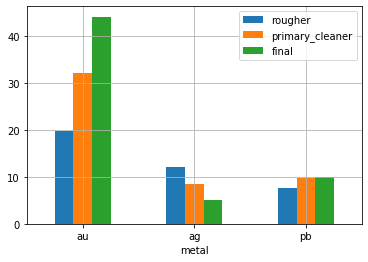

In [20]:
# гистограммы концентрации металлов на различных этапах очистки
conc.plot.bar(grid=True, rot=0)

#### Вывод по концентрации металлов на различных этапах очистки.
Ожидаемо концентрация золота растет. Концентрация свинца тоже увеличивается, но не значительно, а концентрация серебра падает.

### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

In [21]:
# импорт библиотеки matplotlib
import matplotlib.pyplot as plt

In [22]:
# числовое описание обучающей выборки
train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

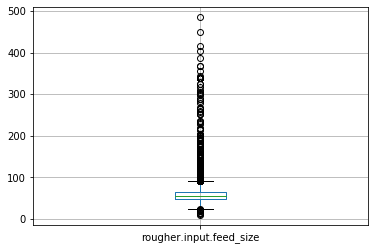

In [23]:
# диаграмма размаха обучающей выборки
train.boxplot(['rougher.input.feed_size'])
plt.show()

In [24]:
# числовое описание тестовой выборки
test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

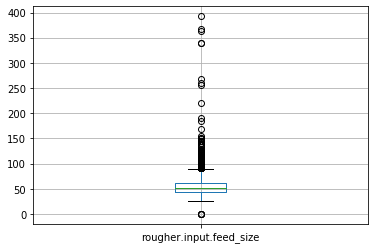

In [25]:
# диаграмма размаха тестовой выборки
test.boxplot(['rougher.input.feed_size'])
plt.show()

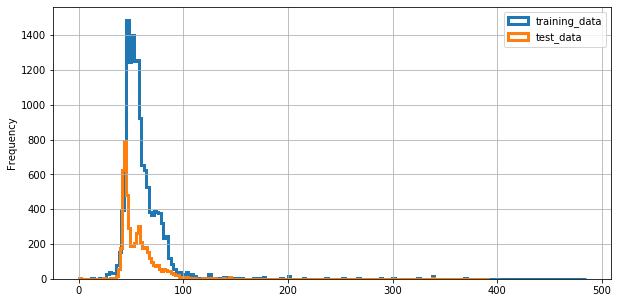

In [26]:
# сравнение гистограмм
train['rougher.input.feed_size'].plot(kind='hist', y='rougher.input.feed_size', histtype='step', bins=200, linewidth=3, alpha=1, label='training_data', legend=True)
test['rougher.input.feed_size'].plot(kind='hist', y='rougher.input.feed_size', histtype='step', bins=200, linewidth=3, alpha=1, label='test_data', legend=True, grid=True, figsize=(10,5))

На диаграммах размаха заметно значительное количество аномальных значений (выбросов). Удалим их и построим гистограммы на нормализованных данных. Аномальными будем считать значения меньше 25%-квартиля минус (k x IQR) и больше 75%-квартиля плюс (k x IQR), где IQR - межквартильный интервал, а k - коэффициент.

In [27]:
# вычислим пределы нормальных значений гранул сырья (в полном датасете), чтобы удалить выбросы
k_s = 1.5 # коэффициент IQR
q1_s = full['rougher.input.feed_size'].quantile(0.25) # квартиль 25%
q3_s = full['rougher.input.feed_size'].quantile(0.75) # квартиль 75%
iqr_s = q3_s - q1_s # межквартильный интервал
low_s = q1_s - k_s*iqr_s # минимальное нормальное значение
high_s = q3_s + k_s*iqr_s # максимальное нормальное значение

In [28]:
# чтобы проконтролировать количество удаленных наблюдений (выбросов) сохраним оригинальное количество
# наблюдений в каждой выборке
len_train2 = len(train)
len_test2 = len(test)
len_full2 = len(full)

In [29]:
# удалим выбросы из всех трех датасетов
train = train[(train['rougher.input.feed_size']>=low_s) & (train['rougher.input.feed_size']<=high_s)]
test = test[(test['rougher.input.feed_size']>=low_s) & (test['rougher.input.feed_size']<=high_s)]
full = full[(full['rougher.input.feed_size']>=low_s) & (full['rougher.input.feed_size']<=high_s)]

In [30]:
# проверим, сколько наблюдений осталось в каждом датасете, и процент аномальных (удаленных) данных
print('Обучающая выборка:', len(train), '   удалено', int((1-len(train)/len_train2)*100), '%')
print('Тестовая выборка:', len(test), '   удалено', int((1-len(test)/len_test2)*100), '%')
print('Полный датасет:', len(full), '   удалено', int((1-len(full)/len_full2)*100), '%')

Обучающая выборка: 13671    удалено 3 %
Тестовая выборка: 5122    удалено 3 %
Полный датасет: 18793    удалено 3 %


In [31]:
import scipy.stats as st

In [32]:
# 95% доверительные интервалы
ci_train = st.t.interval(0.95, len(train['rougher.input.feed_size'])-1,loc=train['rougher.input.feed_size'].mean(), scale=train['rougher.input.feed_size'].sem())
ci_test = st.t.interval(0.95, len(test['rougher.input.feed_size'])-1,loc=test['rougher.input.feed_size'].mean(), scale=test['rougher.input.feed_size'].sem())
print('Обучающая выборка:', ci_train)
print('Тестовая выборка:', ci_test)

Обучающая выборка: (57.33999261661179, 57.73964291864015)
Тестовая выборка: (53.5918633922028, 54.261198866998896)


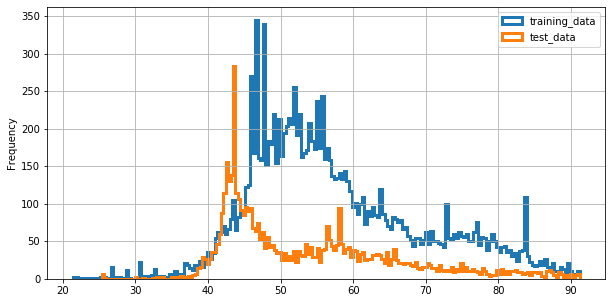

In [33]:
train['rougher.input.feed_size'].plot(kind='hist', y='rougher.input.feed_size', histtype='step', bins=200, linewidth=3, alpha=1, label='training_data', legend=True)
test['rougher.input.feed_size'].plot(kind='hist', y='rougher.input.feed_size', histtype='step', bins=200, linewidth=3, alpha=1, label='test_data', legend=True, grid=True, figsize=(10,5))

#### Вывод по сравнению распределения размеров гранул сырья на обучающей и тестовой выборках.
Судя по числовому описанию распределение на обучающей и тестовой выборках различается незначительно. Но 95% доверительные интервалы смещены и заметно значительное различие гистограмм в районе наиболее частых значений. Можно ожидать, что модель будет работать неточно.

### 2.3. Суммарная концентрация всех веществ на разных стадиях.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Удалим аномалии. Аномальными будем считать значения меньше 25%-квартиля минус (k x IQR) и больше 75%-квартиля плюс (k x IQR), где IQR - межквартильный интервал, а k - коэффициент. 

In [34]:
# коэффициент IQR
k = 1.5

In [35]:
# чтобы проконтролировать количество удаленной информации (аномальных данных о концентрации) сохраним оригинальное количество
# наблюдений в каждой выборке
len_train1 = len(train)
len_test1 = len(test)
len_full1 = len(full)

In [36]:
# список столбцов, содержащих данные о концентрации
full.columns[full.columns.str.contains('concentrate')]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')

In [37]:
# добавим столбцы значений суммарной концентрации всех веществ на каждой стадии:
# rougher_conc_sum, cleaner_conc_sum, final_conc_sum
full['rougher_conc_sum'] = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au']+ full['rougher.output.concentrate_sol']
full['primary_cleaner_conc_sum'] = full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_sol']
full['final_conc_sum'] = full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_au'] + full['final.output.concentrate_sol']               

In [38]:
# вычислим пределы нормальных значений суммарной концентрации на каждой стадии
# и удалим аномальные наблюдения из полного датасета
for step in ['rougher','primary_cleaner','final']:
    column = ''.join([step,'_conc_sum'])
    q1 = full[column].quantile(0.25) # квартиль 25%
    q3 = full[column].quantile(0.75) # квартиль 75%
    iqr = q3 - q1 # межквартильный интервал
    low = q1 - k*iqr # минимальное нормальное значение
    high = q3 + k*iqr # максимальное нормальное значение
    full = full[(full[column]>=low) & (full[column]<=high)] # полный датасет за исключением аномальных значений   

In [39]:
# переиндексируем обучающую и тестовую выборки по дате/времени
train = train.set_index(['date'])
test = test.set_index(['date'])

In [40]:
# создадим списки индексов наблюдений с нормальными значениями концентрации
train_norm_index = set(train.index) & set(full.index) # обучающая выборка
test_norm_index = set(test.index) & set(full.index) # тестовая выборка

In [41]:
# удалим аномальные наблюдения из обучающей и тестовой выборок
train = train.loc[train_norm_index]
test = test.loc[test_norm_index]

In [42]:
# проверим, сколько наблюдений осталось в каждом датасете, и процент аномальных (удаленных) данных
print('Обучающая выборка:', len(train), '   удалено', int((1-len(train)/len_train1)*100), '%')
print('Тестовая выборка:', len(test), '   удалено', int((1-len(test)/len_test1)*100), '%')
print('Полный датасет:', len(full), '   удалено', int((1-len(full)/len_full1)*100), '%')

Обучающая выборка: 11507    удалено 15 %
Тестовая выборка: 4569    удалено 10 %
Полный датасет: 16076    удалено 14 %


#### Вывод по исследованию суммарной концентрации металлов на разных стадиях.
Было обнаружено, что 14% наблюдений содержат аномально высокие значения суммарной концентрации металлов. За пределы нормальной концентрации были приняты значения 25%-квартиля минус межквартильный интервал c коэффициентом 1.5 (1.5хIQR) и 75%-квартиль плюс 1.5хIQR. Возможной причиной может быть ошибочное определение концентрации веществ либо случайный вброс нестандартного сырья.   
Наблюдения с аномальными значениями были исключены из обучающей и тестовой выборок.  

*Примечание:  
На первый взгляд представляется неправильным удалять аномальные значения из тестовой выборки.  
Но само понятие "аномалия" подразумевает нестандартность и исключительность данных. Такие данные не должны использоваться для теста модели.  
Если же считать, что в реальном тестовом наборе данных будут присутствовать такие значения, тогда не следует удалять их из обучающей выборки, дабы модель "знала" о их существовании и могла корректно обучиться. В этом случае будет неправильно называть такие данные "аномальными".* 

### 3. Модель.

### 3.1. Функция для вычисления sMAPE.

In [43]:
def smape_function (targ, pred):
    return sum(abs(targ-pred)/((abs(targ)+abs(pred))/2))/len(targ)*100

In [44]:
# итоговая sMAPE
def rsmape_function(smape1, smape2):
    return 0.25*smape1+0.75*smape2

In [45]:
# подготовим функцию smape для использования в качестве метрики при кросс-валидации
from sklearn.metrics import make_scorer
smape_score = make_scorer(smape_function)

### 3.2. Выбор модели.

In [46]:
# список признаков, присутствующих в обучающей, но отсутствующих в тестовой выборке
extra_features = set(train.columns)-set(test.columns)

In [47]:
# удалим extra_features из обучающей выборки
train = train.drop(columns = extra_features)

In [48]:
# импорт функции масштабирования
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [49]:
# список признаков, которые будем масштабировать
numeric = list(set(train.columns) - set(['rougher.output.recovery', 'final.output.recovery']))

In [50]:
# настраиваем scaler по обучающей выборке
scaler.fit(train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [51]:
# применяем scaler к обучающей выборке
# правильнее было бы применить scaler отдельно к валидационной выборке и к непосредственно обучающей, но это невозможно,
# т.к. выделение валидационной выборки из обучающей будет проходить автоматически при выполнении функции cross_val_score
train[numeric] = scaler.transform(train[numeric])

In [52]:
# переменные для признаков и целевого признака rougher.output.recovery 
# (это только те признаки, которые участвуют в технологическом процессе до и во время прохождения флотации)
features1_list = train.columns[train.columns.str.contains('rougher.')]
features1 = train[features1_list].drop(columns='rougher.output.recovery')
target1 = train['rougher.output.recovery']

In [53]:
# переменные для признаков и целевого признака final.output.recovery
# (должны учитываться все признаки, т.к. все они влияют на эффективность степени обогащения конечного продукта)
features2 = train[numeric]
target2 = train['final.output.recovery']

In [54]:
# заготовка таблицы результатов исследования моделей
columns_mod = ['method', 'n_estimators', 'depth', 'rougher_output_smape', 'final_output_smape', 'resulting_smape']
data_mod=[]

In [55]:
# импорт необходимых функций
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [56]:
# модель линейная регрессия

# создание модели
model1_lr = LinearRegression() # для rougher.output.recovery
model2_lr = LinearRegression() # для final.output.recovery

# расчет значения метрики
scores1_lr = cross_val_score(model1_lr, features1, target1, scoring=smape_score, cv=10)
smape1_lr = scores1_lr.mean() # для rougher.output.recovery
scores2_lr = cross_val_score(model2_lr, features2, target2, scoring=smape_score, cv=10)
smape2_lr = scores2_lr.mean() # для final.output.recovery
rsmape_lr = rsmape_function(smape1_lr, smape2_lr) # итоговая метрика

# добавление строки в таблицу сравнения моделей
data_mod.append(['linear_regression',np.nan, np.nan, smape1_lr, smape2_lr, rsmape_lr])

In [57]:
# вывод результата работы линейной регрессии
summary_mod = pd.DataFrame(data=data_mod, columns=columns_mod)
summary_mod

,method,n_estimators,depth,rougher_output_smape,final_output_smape,resulting_smape
0,linear_regression,NaN,NaN,4.704702,7.103468,6.503776


In [58]:
# модель "решающее дерево" (oграничим глубину дерева)

for md_t in range (6,11,2):
    
    # создание и обучение модели
    model1_t = DecisionTreeRegressor(random_state=12345, max_depth=md_t) # для rougher.output.recovery
    model2_t = DecisionTreeRegressor(random_state=12345, max_depth=md_t) # для final.output.recovery

    # расчет значения метрики
    scores1_t = cross_val_score(model1_t, features1, target1, scoring=smape_score, cv=10)
    smape1_t = scores1_t.mean() # для rougher.output.recovery
    scores2_t = cross_val_score(model2_t, features2, target2, scoring=smape_score, cv=10)
    smape2_t = scores2_t.mean() # для final.output.recovery
    rsmape_t = rsmape_function(smape1_t, smape2_t) # итоговая метрика

    # добавление строк в таблицу сравнения моделей
    data_mod.append(['decision_tree',np.nan, md_t, smape1_t, smape2_t, rsmape_t])

In [59]:
# вывод таблицы сравнения моделей линейной регрессии и дерева решений
summary_mod = pd.DataFrame(data=data_mod, columns=columns_mod)
summary_mod

,method,n_estimators,depth,rougher_output_smape,final_output_smape,resulting_smape
0,linear_regression,NaN,NaN,4.704702,7.103468,6.503776
1,decision_tree,NaN,6.0,3.861998,6.732230,6.014672
2,decision_tree,NaN,8.0,3.426871,6.455891,5.698636
3,decision_tree,NaN,10.0,3.139133,6.359250,5.554221


In [60]:
# выбор глубины лучшего решающего дерева
tree = summary_mod.query('method=="decision_tree"')
md_f = int(tree.loc[(tree['resulting_smape']== tree['resulting_smape'].min()),'depth'])
md_f

10

In [61]:
%%time

# модель "случайный лес"

# переберем значения n_estimators,
# oграничим макс глубину деревьев глубиной лучшего варианта из модели решающего дерева (в целях экономии времени расчета),

for estim in range (30,51,10):

    # создание и обучение модели
    model1_f = RandomForestRegressor(n_estimators=estim, max_depth=md_f, random_state=12345) # для rougher.output.recovery
    model2_f = RandomForestRegressor(n_estimators=estim, max_depth=md_f, random_state=12345) # для final.output.recovery
        
    # расчет значения метрики
    scores1_f = cross_val_score(model1_f, features1, target1, scoring=smape_score, cv=10)
    smape1_f = scores1_f.mean() # для rougher.output.recovery
    scores2_f = cross_val_score(model2_f, features2, target2, scoring=smape_score, cv=10)
    smape2_f = scores2_f.mean() # для final.output.recovery
    rsmape_f = rsmape_function(smape1_f,smape2_f) # итоговая метрика

    # добавление строк в таблицу сравнения моделей
    data_mod.append(['random_forest', estim, md_f, smape1_f, smape2_f, rsmape_f])

CPU times: user 9min 19s, sys: 316 ms, total: 9min 19s
Wall time: 9min 25s


In [62]:
# вывод таблицы сравнения моделей
summary_mod = pd.DataFrame(data=data_mod, columns=columns_mod)
summary_mod

,method,n_estimators,depth,rougher_output_smape,final_output_smape,resulting_smape
0,linear_regression,NaN,NaN,4.704702,7.103468,6.503776
1,decision_tree,NaN,6.0,3.861998,6.732230,6.014672
2,decision_tree,NaN,8.0,3.426871,6.455891,5.698636
3,decision_tree,NaN,10.0,3.139133,6.359250,5.554221
4,random_forest,30.0,10.0,2.740096,5.521785,4.826362
5,random_forest,40.0,10.0,2.731695,5.523139,4.825278
6,random_forest,50.0,10.0,2.729067,5.508589,4.813709


In [63]:
# выбор лучшей модели
best_mod=summary_mod[summary_mod['resulting_smape']==summary_mod['resulting_smape'].min()].reset_index(drop=True)
best_mod

,method,n_estimators,depth,rougher_output_smape,final_output_smape,resulting_smape
0,random_forest,50.0,10.0,2.729067,5.508589,4.813709


In [64]:
estim_best = int(best_mod.loc[0,'n_estimators'])
depth_best = int(best_mod.loc[0,'depth'])

### 3.3. Проверка модели на тестовой выборке.

In [65]:
# масштабирование тестовой выборки (scaler уже настроен по обучающей)
test[numeric] = scaler.transform(test[numeric])

In [66]:
# переменные для признаков и целевого признака rougher.output.recovery 
# (это только те признаки, которые участвуют в технологическом процессе до и во время прохождения флотации)
features1_list_test = test.columns[test.columns.str.contains('rougher.')]
features1_test = test[features1_list_test].drop(columns='rougher.output.recovery')
target1_test = test['rougher.output.recovery']

In [67]:
# переменные для признаков и целевого признака final.output.recovery
# (должны учитываться все признаки, т.к. все они влияют на эффективность степени обогащения конечного продукта)
features2_test = test[numeric]
target2_test = test['final.output.recovery']

In [68]:
# создание модели
model1 = RandomForestRegressor(n_estimators=estim_best, max_depth=depth_best, random_state=12345)
model2 = RandomForestRegressor(n_estimators=estim_best, max_depth=depth_best, random_state=12345)

In [69]:
# обучение модели
model1.fit(features1, target1)
model2.fit(features2, target2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [70]:
# работа модели - формирование предсказанных значений
pred1_test = model1.predict(features1_test)
pred2_test = model2.predict(features2_test)

In [71]:
# расчет метрики
smape1_test = smape_function(target1_test, pred1_test)
smape2_test = smape_function(target2_test, pred2_test)
rsmape_test = rsmape_function(smape1_test, smape2_test)

In [72]:
# формирование таблицы результата
result_test = best_mod
result_test['rougher_output_smape'] = smape1_test
result_test['final_output_smape'] = smape2_test
result_test['resulting_smape'] = rsmape_test

In [73]:
# вывод результата
result_test

,method,n_estimators,depth,rougher_output_smape,final_output_smape,resulting_smape
0,random_forest,50.0,10.0,4.022642,7.278134,6.464261


Проверим выбранную модель на адекватность - сравненим с константной dummy-моделью.

In [74]:
from sklearn.dummy import DummyRegressor

In [75]:
# создание dummy-модели
dummy1 = DummyRegressor(strategy='mean')
dummy2 = DummyRegressor(strategy='mean')

In [76]:
# обучение dummy-модели
dummy1.fit(features1, target1)
dummy2.fit(features2, target2)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [77]:
# работа dummy-модели - формирование предсказанных значений
pred1_dummy = dummy1.predict(features1_test)
pred2_dummy = dummy2.predict(features2_test)

In [78]:
# расчет метрики
smape1_dummy = smape_function(target1_test, pred1_dummy)
smape2_dummy = smape_function(target2_test, pred2_dummy)
rsmape_dummy = rsmape_function(smape1_dummy, smape2_dummy)

In [79]:
# добавление строки dummy в таблицу результата
line_dummy = ['dummy', np.nan, np.nan, smape1_dummy, smape2_dummy, rsmape_dummy]
result_test.loc[1,:] = line_dummy
result_test

,method,n_estimators,depth,rougher_output_smape,final_output_smape,resulting_smape
0,random_forest,50.0,10.0,4.022642,7.278134,6.464261
1,dummy,NaN,NaN,4.767457,7.703849,6.969751


Значение метрики (ошибки) выбранной модели меньше ошибки dummy-модели, т.е. выбранная модель адекватна. 

### 4. Вывод.

Была проделана следующая работа.

Данные загружены, изучены и подготовлены к работе:  
Проверена правильность расчёта эффективности обогащения. Выяснено, что в тестовой выборке отсутствуют признаки, описывающие параметры конечного продукта и сырья, прошедшего частичную обработку. Поэтому значения целевых признаков были скопированы из полного датасета в тестовую выборку. Строки с пропущенными значениями целевых признаков (rougher.output.recovery и
final.output.recovery) были удалены. Пропуски нецелевых признаков были заполнены ближайшими значениями.  

Произведен анализ технологических данных:
Проанализировали концентрацию металлов (Au, Ag, Pb) на различных этапах очистки. Было выяснено, что концентрация золота растет. Концентрация свинца тоже увеличивается, но не значительно, а концентрация серебра падает.  
Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках. Сравнение произвели путем анализа числового описания, 95% доверительного интервала и построения гистограмм. Судя по числовому описанию распределение на обучающей и тестовой выборках различается незначительно. Но 95% доверительные интервалы смещены и заметно значительное различие гистограмм в районе наиболее частых значений. Можно ожидать, что модель будет работать неточно. Наблюдения с аномальными значениями размеров гранул удалили.    
Исследовали суммарную концентрацию всех веществ на разных стадиях, аномалии удалили.  

Введена метрика sMAPE для оценки эффективности обогащения чернового и финального концентратов. В качестве итоговой метрики использовано взвешенное значение sMAPE чернового и финального концентратов.

Были изучены результаты работы моделей линейной регрессии, дерева решений и случайного леса.  
В качестве признаков для предсказания оценки эффективности обогащения чернового концентрата (rougher.output.recovery) были использованы только те данные, которые участвуют в технологическом процессе до и во время прохождения флотации (стадия rougher).  
Для предсказания оценки эффективности обогащения финального концентрата (final.output.recovery) учли все признаки, т.к. все они влияют на эффективность степени обогащения конечного продукта.  
Выбор модели производился с применением метода кросс-валидации, реализованного с помощью библиотеки scikit.  

Лучший результат показала модель "случайный лес". sMAPE обогащения чернового и финального концентрата и итоговая sMAPE тестовой выборки приведены в таблице result_test.  
Адекватность выбранной модели проверили путем сравнения с константной моделью (с использованием среднего значения).

#### Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке